In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt

import deblending_runjingdev.sdss_dataset_lib as sdss_dataset_lib
import deblending_runjingdev.image_utils as image_utils

import deblending_runjingdev.starnet_lib as starnet_lib

import sys
sys.path.insert(0, '../')
from sparse_field_lib import load_data

import json

np.random.seed(34534)

from deblending_runjingdev.which_device import device
print('device: ', device)


device:  cuda:6


# Load data

In [2]:
bands = [2]

In [3]:
image_full, coadd_fits_file, wcs_list, sdss_data = load_data(sdss_dir='../../sdss_stage_dir/', 
                                                             bands = bands, 
                                                             align_bands = False)

image_full = image_full.to(device)

loading sdss image from ../../sdss_stage_dir/94/1/12/frame-r-000094-1-0012.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '19/09/98' to '1998-09-19''. [astropy.wcs.wcs]


## Get coadded catalog

In [4]:
true_ra = coadd_fits_file['ra'][:]
true_decl = coadd_fits_file['dec'][:]

true_mag_r = coadd_fits_file['psfmag_r'][:]
true_mag_i = coadd_fits_file['psfmag_i'][:]

which_stars = (coadd_fits_file['probpsf'][:] == 1)
which_galx = (coadd_fits_file['probpsf'][:] == 0) 

which_bright_stars = (coadd_fits_file['probpsf'][:] == 1) & (true_mag_r < 22)
which_bright_galx = (coadd_fits_file['probpsf'][:] == 0) & (true_mag_r < 22)

In [5]:
# convert magnitude to fluxes
true_mags = torch.Tensor([true_mag_r, true_mag_i]).transpose(0, 1)
nelec_per_nmgy = torch.Tensor(sdss_data[0]['nelec_per_nmgy'].mean(-1))

true_fluxes = sdss_dataset_lib.convert_mag_to_nmgy(true_mags) * nelec_per_nmgy.unsqueeze(0)

In [6]:
pix_coords = wcs_list[0].wcs_world2pix(true_ra, true_decl, 0, ra_dec_order = True)

In [7]:
# note! unlike before, these are pixel coordinates, not parameterized between 0 and 1
true_locs = torch.Tensor([pix_coords[1], pix_coords[0]]).transpose(0, 1)

# Load encoder

In [8]:
star_encoder = starnet_lib.StarEncoder(slen = 500, 
                                       ptile_slen = 50,
                                       step = 50,
                                       edge_padding = 0,
                                       n_bands = len(bands), 
                                       max_detections = 3, 
                                       track_running_stats = False)


In [9]:
star_encoder.load_state_dict(torch.load('../starnet_sparsefield', 
                               map_location=lambda storage, loc: storage))


star_encoder.eval(); 
star_encoder.to(device);

# Get StarNet catalog

In [10]:
### patch the full image

# take the first 1450 x 2000 pixels : so the image is a whole-multiple of tiles
image_patches = image_utils.tile_images(image_full[:, 0:1450, 0:2000].unsqueeze(0), 
                                        subimage_slen = star_encoder.ptile_slen, 
                                        step = star_encoder.step)

tile_coords = image_utils.get_tile_coords(1450, 2000, 
                                          subimage_slen = star_encoder.ptile_slen, 
                                          step = star_encoder.step)

In [11]:
patch_loc_mean, patch_loc_log_var, \
    patch_log_flux_mean, patch_log_flux_log_var, patch_log_probs = star_encoder(image_patches)

In [12]:
# time for a forward pass
%timeit star_encoder(image_patches)

23.9 ms ± 13.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
map_locs, map_fluxes, map_n_stars = \
    image_utils.get_full_params_from_tile_params(patch_loc_mean,
                                                 patch_log_flux_mean,
                                                 tile_coords,
                                                 full_slen = 1450,
                                                 stamp_slen = star_encoder.ptile_slen,
                                                 edge_padding = 0.0,
                                                 full_slen2 = 2000)

In [14]:
map_locs_x0 = map_locs[0, :, 0].detach() * (1450 - 1)
map_locs_x1 = map_locs[0, :, 1].detach() * (2000 - 1)

In [15]:
map_locs = torch.stack([map_locs_x0, map_locs_x1]).transpose(0, 1)

# Get PHOTO results

In [16]:
import fitsio

In [17]:
photo_fits_file = fitsio.FITS('./../../sdss_stage_dir/94/1/12/photoObj-000094-1-0012.fits')[1]

In [18]:
photo_is_star = photo_fits_file['type'][:][:, 2] == 6

photo_is_star.sum()

456

In [19]:
photo_ra = photo_fits_file['ra'][:][photo_is_star]
photo_decl = photo_fits_file['dec'][:][photo_is_star]

photo_mag_r = photo_fits_file['PSFMAG'][:][:, 2][photo_is_star]
photo_mag_i = photo_fits_file['PSFMAG'][:][:, 3][photo_is_star]

photo_which_bright = (photo_mag_r < 22)

In [20]:
photo_pix_coords = wcs_list[0].wcs_world2pix(photo_ra, photo_decl, 0, ra_dec_order = True)

In [21]:
photo_locs = torch.Tensor([photo_pix_coords[1], photo_pix_coords[0]]).transpose(0, 1)

# check out a subimage

In [22]:
def add_points(fig, est_locs, x0, x1, subimage_slen, 
               color = 'c', marker = 'x', alpha = 1.0, markersize = 12): 

    which_locs = (est_locs[:, 0] > x0) & \
                    (est_locs[:, 0] < (x0 + subimage_slen - 1)) & \
                    (est_locs[:, 1] > x1) & \
                    (est_locs[:, 1] < (x1 + subimage_slen - 1))
    
    locs_filtered = (est_locs[which_locs, :] - torch.Tensor([[x0, x1]]))
    
    fig.scatter(locs_filtered[:, 1].cpu().numpy(),
                locs_filtered[:, 0].cpu().numpy(), 
                color = color,
                marker = marker,
                alpha = alpha, 
                s = markersize)

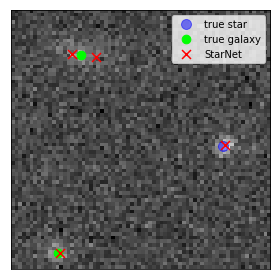

In [23]:
# x0 = 505
# x1 = 505
# subimage_slen = 500

x0 = 1180
x1 = 180
subimage_slen = 70

f, axarr = plt.subplots(1, 1, figsize=(4, 4))

tmp_image = image_full[0, x0:(x0 + subimage_slen), x1:(x1 + subimage_slen)].cpu().numpy()
axarr.matshow(tmp_image,
              cmap=plt.cm.gray)

# plot true star locations
add_points(axarr, 
           true_locs[which_bright_stars], 
           x0,
           x1,
           subimage_slen = subimage_slen, 
           color = 'b',
           marker = 'o',
           alpha = 0.5,
           markersize = 100)

# plot true galaxy locations
add_points(axarr, 
           true_locs[which_bright_galx], 
           x0,
           x1,
           subimage_slen = subimage_slen, 
           color = 'lime', 
           marker = 'o', 
           alpha = 1.0, 
           markersize = 75)

# plot PHOTO detections
# add_points(axarr, photo_locs,
#            x0, x1, subimage_slen = subimage_slen, 
#            color = 'c', marker = 'x', alpha = 1.0, markersize = 80)

# plot StarNet detections
add_points(axarr, 
           map_locs.cpu(),
           x0, 
           x1,
           subimage_slen = subimage_slen, 
           color = 'r',
           marker = 'x', 
           alpha = 1.0,
           markersize = 80)

axarr.legend(('true star', 'true galaxy', 'StarNet'))

axarr.set_xticks([]);
axarr.set_yticks([]);

f.tight_layout()
f.savefig('../../figures/sparse_field/sparse_field_detections.png')

# Get summary statistics

In [24]:
def get_loc_error_on_subimage(est_locs, true_locs, x0, x1, subimage_slen0, subimage_slen1): 
    # Here est locs and true locs are in pixel coordinates! 
    
    which_est_locs = (est_locs[:, 0] > x0) & \
                    (est_locs[:, 0] < (x0 + subimage_slen0 - 1)) & \
                    (est_locs[:, 1] > x1) & \
                    (est_locs[:, 1] < (x1 + subimage_slen1 - 1))
    
    est_locs_filtered = est_locs[which_est_locs, :] 
    
    which_true_locs = (true_locs[:, 0] > x0) & \
                    (true_locs[:, 0] < (x0 + subimage_slen0 - 1)) & \
                    (true_locs[:, 1] > x1) & \
                    (true_locs[:, 1] < (x1 + subimage_slen1 - 1))
    
    true_locs_filtered = true_locs[which_true_locs, :] 
    
    # L\inf error 
    # true locs x est locs
    error_mat = torch.abs(est_locs_filtered.unsqueeze(0) - true_locs_filtered.unsqueeze(1)).max(2)[0]
    
    # for each true loc find closest estimated loc
    error_vec = error_mat.min(1)[0]
        
    return error_vec

### Get tpr as function of magnitude

In [25]:
bins = np.concatenate((np.array([15]), 
                          np.arange(19, 22.2, 0.4), 
                          np.array([100])))

In [26]:
tpr_vec = np.zeros(len(bins) - 1)
for i in range(len(bins) - 1): 
    which_mags = (true_mag_r > bins[i]) & (true_mag_r < bins[i + 1])
    
    print('n-true stars: ', (which_stars & which_mags).sum())
    
    error = get_loc_error_on_subimage(map_locs.cpu(),
                                      true_locs[which_stars & which_mags].cpu(), 
                                      x0 = 100, x1 = 100, 
                                      subimage_slen0 = 1300, 
                                      subimage_slen1 = 1900)
    
    tpr_vec[i] = (error < 5).float().mean()

n-true stars:  77
n-true stars:  10
n-true stars:  14
n-true stars:  13
n-true stars:  22
n-true stars:  30
n-true stars:  34
n-true stars:  34
n-true stars:  112


In [27]:
photo_tpr_vec = np.zeros(len(bins) - 1)
for i in range(len(bins) - 1): 
    which_mags = (true_mag_r > bins[i]) & (true_mag_r < bins[i + 1])
    
    error = get_loc_error_on_subimage(photo_locs, 
                                      true_locs[which_stars & which_mags], 
                                      x0 = 100, x1 = 100, 
                                      subimage_slen0 = 1300, 
                                      subimage_slen1 = 1900)
    
    photo_tpr_vec[i] = (error < 5).float().mean()

In [28]:
axis_label_size = 16
ticksize = 12
legendsize = 12
markersize = 10
linewidth = 2

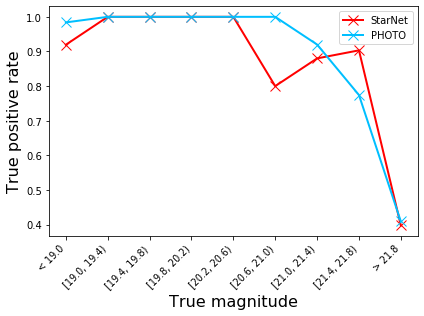

In [29]:
fig, axarr = plt.subplots(1, 1, figsize=(6, 4.5))

x_tmp = np.arange(len(bins) - 1)

axarr.plot(x_tmp, tpr_vec, '-x', 
              markersize = markersize, linewidth = linewidth,
              color = 'r', label = 'StarNet')


axarr.plot(x_tmp, photo_tpr_vec, '-x', 
              markersize = markersize, linewidth = linewidth,
              color = 'deepskyblue', label = 'PHOTO')

axarr.set_xlabel('True magnitude', fontsize = axis_label_size)
axarr.set_ylabel('True positive rate', fontsize = axis_label_size)

axarr.legend()


labels_raw = np.round(bins, 1)
labels = ['[' + str(labels_raw[i]) + ', ' + str(labels_raw[i+1]) + ')' for i in range(len(labels_raw) - 1)]

labels[0] = '< ' + str(labels_raw[1])
labels[-1] = '> ' + str(labels_raw[-2])

axarr.set_xticks(x_tmp)
axarr.set_xticklabels(labels,
                      rotation=45,
                      ha = 'right', 
                      fontsize = axis_label_size * 0.6);

fig.tight_layout()
fig.savefig('../../figures/sparse_field/sparse_field_tpr.png')